In [2]:
!pip install git+https://github.com/jkirkby3/pymle.git

  Cloning https://github.com/jkirkby3/pymle.git to c:\users\onesmile\appdata\local\temp\pip-req-build-anybldq1
  Resolved https://github.com/jkirkby3/pymle.git to commit 412f74f5201782686f13ed2c60acd07b740c42e8
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/jkirkby3/pymle.git 'C:\Users\OneSmiLe\AppData\Local\Temp\pip-req-build-anybldq1'

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np, scipy.stats as st
import matplotlib.dates as mdates


from scipy.stats import norm
from tqdm import tqdm
from pymle.models import CIR, CKLS, OrnsteinUhlenbeck
from pymle.sim.Simulator1D import Simulator1D
from pymle.core.TransitionDensity import ExactDensity, KesslerDensity, OzakiDensity, EulerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE

In [62]:
from tabulate import tabulate
import numpy as np

class ModelEstimator:
    def __init__(self, sample, models, model_names, param_bounds, param_guesses, dt=1./252):
        self.sample = sample
        self.models = models
        self.model_names = model_names
        self.param_bounds = param_bounds
        self.param_guesses = param_guesses
        self.dt = dt
        self.results = {'Kessler': {}, 'Shoji-Ozaki': {}, 'Euler': {}}

    def estimate_params(self, method, model, param_bounds, param_guess):
        """
        Estimate parameters using the given method and model.
        """
        if method == 'Kessler':
            density = KesslerDensity(model)
        elif method == 'Shoji-Ozaki':
            density = ShojiOzakiDensity(model)
        elif method == 'Euler':
            density = EulerDensity(model)
        else:
            raise ValueError(f"Unknown method {method}")
        
        estimator = AnalyticalMLE(self.sample, param_bounds, self.dt, density=density)
        result = estimator.estimate_params(param_guess)
        return result.aic, result.params

    def fit_models(self):
        """
        Estimate parameters for each model using each method.
        """
        for method in self.results.keys():
            for i, model in enumerate(self.models):
                aic, params = self.estimate_params(method, model, self.param_bounds[i], self.param_guesses[i])
                self.results[method][self.model_names[i]] = {'aic': aic, 'params': params}

    def print_aic_results(self):
        """
        Print AIC results for all models and methods.
        """
        for method, data in self.results.items():
            print(f"\n{'='*40}")
            print(f"AIC values for {method} estimation:")
            print(f"{'Model':<20} {'AIC':<10} {'Parameters'}")
            print("-" * 40)
            for model in self.model_names:
                aic = data[model]['aic']
                params = data[model]['params']
                print(f"{model:<20} {aic:<10.3f} {params}")
            print("="*40)

    def print_best_model(self):
        """
        Print the best model for each method (based on the lowest AIC).
        """
        for method, data in self.results.items():
            best_model = min(data, key=lambda x: data[x]['aic'])  # Model with the lowest AIC
            best_params = data[best_model]['params']
            print(f"\n{'='*40}")
            print(f"Best model for {method} estimation:")
            print(f"{'Model':<20} {best_model}")
            print(f"{'Parameters':<20} {best_params}")
            print("="*40)

    def print_combined_results(self):
        """
        Print the combined best model results across all methods.
        """
        best_models = {
            'Kessler': min(self.results['Kessler'], key=lambda x: self.results['Kessler'][x]['aic']),
            'Shoji-Ozaki': min(self.results['Shoji-Ozaki'], key=lambda x: self.results['Shoji-Ozaki'][x]['aic']),
            'Euler': min(self.results['Euler'], key=lambda x: self.results['Euler'][x]['aic'])
        }

        print(f"\n{'='*40}")
        print("Combined Best Models Across All Methods:")
        print(f"{'Method':<15} {'Best Model':<20} {'Parameters'}")
        print("-" * 40)
        for method in ['Kessler', 'Shoji-Ozaki', 'Euler']:
            best_model = best_models[method]
            best_params = self.results[method][best_model]['params']
            print(f"{method:<15} {best_model:<20} {best_params}")
        print("="*40)

In [2]:
# Define auxiliary function to find minimal value
def argmin(iterable):
    return min(enumerate(iterable), key=lambda x: x[1])[0]

Task 1. Constant Maturity Interest Rates. Fit models (CEV, CIR, OU, CKLS) to a sample of historical interest rates over the period Jan 1, 1962 to till now. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using MLE approach.

The estimated parameters display in a table for each method. Calculate the AIC and select the best model. Compare your results with paper by Kirkby et. al (https://arxiv.org/abs/2108.12649) where the period from Jan 1, 1962 to April 8, 2021 (14,801 daily observations).

Dataset: Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (DGS10),
https://fred.stlouisfed.org/series/DGS10  

In [3]:
df_IR = pd.read_csv('DGS10.csv')
df_IR = df_IR[df_IR['DGS10'] != '.']

sample = df_IR['DGS10'].values
sample = [float(sample[i]) for i in range(len(sample))]
sample = np.array(sample)

Task. Download the DGS10 dataset directlly from https://fred.stlouisfed.org/series/DGS10 .

Hint.

Use  
`from pymle.data.loader import load_10yr_CMrate`

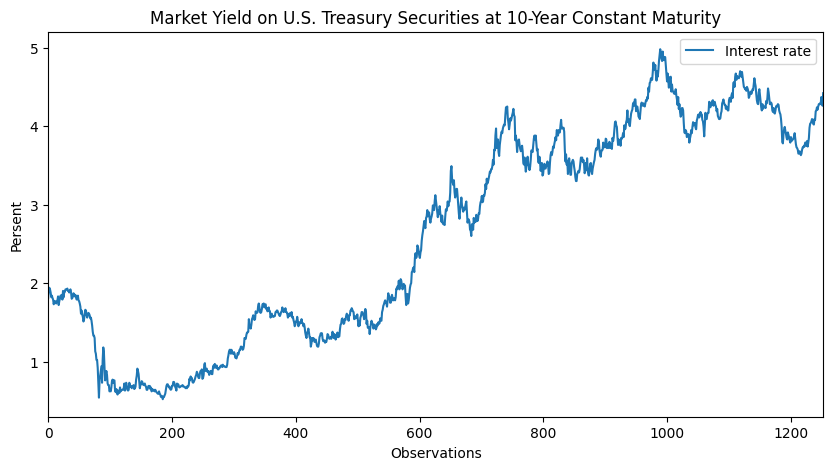

In [4]:
from pymle.data.loader import load_10yr_CMrate

figure, ax = plt.subplots(figsize=(10,5))
ax.plot(np.linspace(0, len(sample), len(sample)),sample, label='Interest rate')
plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')
plt.xlim(0, len(sample))
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

Task. Change the X marks to dates.

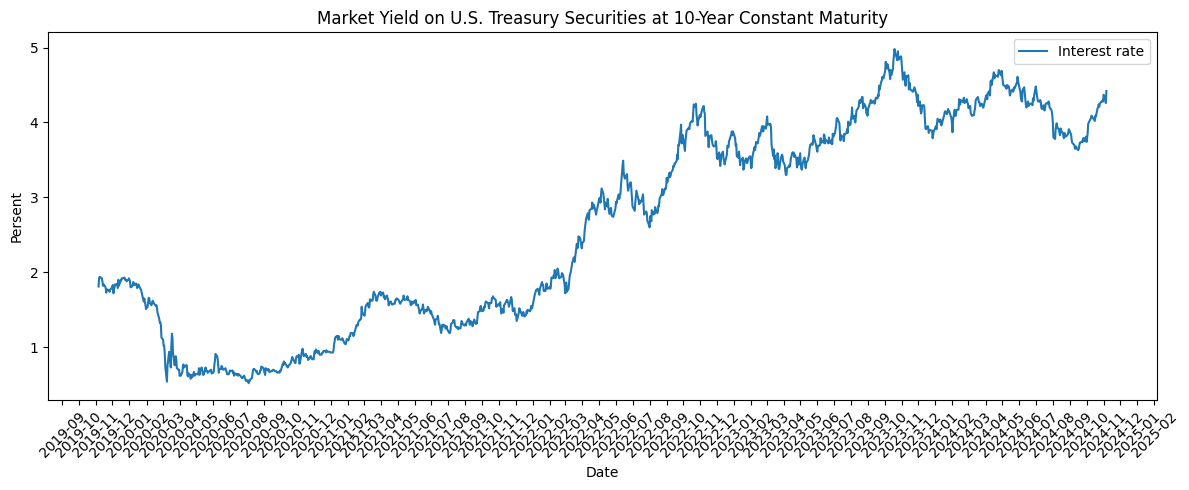

In [5]:
df_IR['DATE'] = pd.to_datetime(df_IR['DATE'], errors='coerce')
df_IR = df_IR.dropna(subset=['DATE'])
data = df_IR['DATE']

figure, ax = plt.subplots(figsize=(12, 5))

ax.plot(data, sample, label='Interest rate')

ax.xaxis.set_major_locator(mdates.MonthLocator())  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)

plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')
plt.ylabel('Persent')
plt.xlabel('Date')

plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Import models for fitting:
from pymle.models import BrownianMotion, CEV, CIR,\
                         CKLS, GeometricBM, IGBM, \
                         OrnsteinUhlenbeck

In [7]:


model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]



param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]






In [8]:
def get_results( model_name, est, params):
    best_ind = argmin(est)
    print("AIC values for Shoji-Ozaki estimation:\n \
        {:.3f} - {} model with params {},\n \
        {:.3f} - {} model with params {},\n \
        {:.3f} - {} model with params {},\n \
        {:.3f} - {} model with params {},\n \
        {:.3f} - {} model with params {},\n \
        {:.3f} - {} model with params {},\n \
        {:.3f} - {} model with params {},\n \
        ".format(
        est[0], model_name[0], params[0],\
        est[1], model_name[1], params[1],\
        est[2], model_name[2], params[2],\
        est[3], model_name[3], params[3],\
        est[4], model_name[4], params[4],\
        est[5], model_name[5], params[5],\
        est[6], model_name[6], params[6]))

    print("The best model is {} \
        with param {}".format(model_name[best_ind], params[best_ind]))
    return best_ind
    





In [9]:
# a) fit using Kessler method:
# Set parameters for estimators:

def kessler(sample, param_bounds, param_guess):
    dt = 1. / 252
    kessler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
                for i in range (len(param_bounds))]
    kessler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                for i in range (len(param_bounds))]
    return kessler_est, kessler_params


def shoji_Ozaki(sample, param_bounds, param_guess):
    dt = 1. / 252
    K = 1

    shoji_ozaki_est      = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
                for i in range (len(param_bounds))]
    shoji_ozaki_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                for i in range (len(param_bounds))]
    return shoji_ozaki_est, shoji_ozaki_params



def euler(sample, param_bounds, param_guess):
# Estimate max likelyhood, using Shoji-Ozaki
    dt = 1. / 252
    K = 1
    euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
                for i in range (len(param_bounds))]
    eu_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                for i in range (len(param_bounds))]
    
    return euler_est, eu_params

In [10]:
kessler_est, kessler_params = kessler(sample=sample, param_bounds=param_bounds, param_guess=param_guess)

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.663678525556
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 102, CG iterations: 61, optimality: 5.73e-04, constraint violation: 0.00e+00, execution time: 0.16 s.
Final Params: [0.52579749 0.99606111]
Final Likelihood: 1688.5031351348089
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.47065226873


c:\Users\OneSmiLe\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 64, function evaluations: 385, CG iterations: 191, optimality: 2.60e+00, constraint violation: 0.00e+00, execution time: 0.32 s.
Final Params: [0.04125675 0.46069954 0.82189442 0.22058145]
Final Likelihood: 1713.4848951565245
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2720.3413110449023
`xtol` termination condition is satisfied.
Number of iterations: 45, function evaluations: 144, CG iterations: 73, optimality: 1.25e+00, constraint violation: 0.00e+00, execution time: 0.091 s.
Final Params: [0.03024065 0.20952716 0.68507541]
Final Likelihood: 1668.7232686979805
Initial Params: [0.01, 0.2]
Initial Likelihood: -952.570413375402
`xtol` termination condition is satisfied.
Number of iterations: 46, function evaluations: 111, CG iterations: 63, optimality: 6.88e-01, constraint violation: 0.00e+00, execution time: 0.068 s.
Final Params: [0.33286208 0.59321773]
Final Likelihood: 1355.184604928842
Initial Params: [0.01

In [11]:
shoji_ozaki_est, shoji_ozaki_params =  shoji_Ozaki(sample, param_bounds, param_guess)


Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.663678524914
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 72, CG iterations: 41, optimality: 4.92e-07, constraint violation: 0.00e+00, execution time:  0.1 s.
Final Params: [0.52575818 0.99606105]
Final Likelihood: 1688.5031351392488
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.5899890722
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 986, optimality: 1.02e-02, constraint violation: 0.00e+00, execution time: 0.91 s.
Final Params: [0.03255211 0.10318146 0.81980498 0.22399328]
Final Likelihood: 1713.4982848279833
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2722.38146138146
`xtol` termination condition is satisfied.
Number of iterations: 121, function evaluations: 492, CG iterations: 271, optimality: 3.57e-02, constraint violation: 0.00e+00, execution time: 0.31 s.
Final Params: [

In [12]:
euler_est, eu_params = euler(sample, param_bounds, param_guess)

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.663678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.92e-07, constraint violation: 0.00e+00, execution time: 0.12 s.
Final Params: [0.52575792 0.99606105]
Final Likelihood: 1688.5031351392522
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 82, function evaluations: 425, CG iterations: 201, optimality: 5.44e-06, constraint violation: 0.00e+00, execution time: 0.26 s.
Final Params: [0.08517402 8.74386331 0.81883612 0.22428031]
Final Likelihood: 1714.574878581613
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2722.1718500081256
`xtol` termination condition is satisfied.
Number of iterations: 69, function evaluations: 240, CG iterations: 140, optimality: 3.79e-06, constraint violation: 0.00e+00, execution time: 0.16 s.
Final Params: [0.1066357  7.5

In [13]:
best_ind_kessler = get_results(model_name, kessler_est, kessler_params)

AIC values for Shoji-Ozaki estimation:
         -3373.006 - BrownianMotion model with params [0.52579749 0.99606111],
         -3418.970 - CEV model with params [0.04125675 0.46069954 0.82189442 0.22058145],
         -3331.447 - CIR model with params [0.03024065 0.20952716 0.68507541],
         -2706.369 - GeometricBM model with params [0.33286208 0.59321773],
         -2712.736 - IGBM model with params [0.71923198 2.60371981 0.59091242],
         -3371.148 - OrnsteinUhlenbeck model with params [0.1403875  6.30142755 0.99599643],
         -3420.836 - CKLS model with params [0.29538323 0.07944823 0.81900903 0.2255426 ],
         
The best model is CKLS         with param [0.29538323 0.07944823 0.81900903 0.2255426 ]


In [14]:
best_ind_shoji = get_results(model_name,shoji_ozaki_est, shoji_ozaki_params )

AIC values for Shoji-Ozaki estimation:
         -3373.006 - BrownianMotion model with params [0.52575818 0.99606105],
         -3418.997 - CEV model with params [0.03255211 0.10318146 0.81980498 0.22399328],
         -3334.016 - CIR model with params [0.1673796  5.30425895 0.68441537],
         -2708.610 - GeometricBM model with params [0.37100309 0.59464941],
         -2710.894 - IGBM model with params [0.3228827  3.9098845  0.59445164],
         -3371.126 - OrnsteinUhlenbeck model with params [0.07301196 9.97354728 0.99615877],
         -3420.717 - CKLS model with params [0.3138487  0.12132496 0.81868687 0.22442916],
         
The best model is CKLS         with param [0.3138487  0.12132496 0.81868687 0.22442916]


In [15]:
best_ind_euler = get_results(model_name, euler_est, eu_params)

AIC values for Shoji-Ozaki estimation:
         -3373.006 - BrownianMotion model with params [0.52575792 0.99606105],
         -3421.150 - CEV model with params [0.08517402 8.74386331 0.81883612 0.22428031],
         -3334.053 - CIR model with params [0.1066357  7.54333943 0.68420268],
         -2708.614 - GeometricBM model with params [0.35407027 0.59508579],
         -2710.938 - IGBM model with params [0.41318064 3.24222206 0.59405827],
         -3371.151 - OrnsteinUhlenbeck model with params [0.12451611 6.83542174 0.99600333],
         -3421.059 - CKLS model with params [0.53384366 0.01000671 0.81883098 0.22433494],
         
The best model is CEV         with param [0.08517402 8.74386331 0.81883612 0.22428031]


In [16]:
list_best_ind = [best_ind_kessler,  best_ind_shoji, best_ind_euler,]

model_name_best_ind = [model_name[x] for x in list_best_ind]

print("For the best model {}\n \
    params are:\n \
    {},\n \
    {},\n \
    {}".format(
    model_name_best_ind,\
    kessler_params[best_ind_kessler],\
    shoji_ozaki_params[best_ind_shoji],\
    eu_params[best_ind_euler]))

For the best model ['CKLS', 'CKLS', 'CEV']
     params are:
     [0.29538323 0.07944823 0.81900903 0.2255426 ],
     [0.3138487  0.12132496 0.81868687 0.22442916],
     [0.08517402 8.74386331 0.81883612 0.22428031]


In [17]:
shoji_ozaki_p = [0.01190742, 0.6541825, 0.57703004, 0.32514395]
kessler_p     = [0.02011782, 0.13874663, 0.567096, 0.33594728]
euler_p       = [0.06504598, 5.87897445, 0.57674668, 0.32538039]

Task: Rewrite code and pass estimated parameters programmatically.

In [41]:
# Определение моделей и методов оценки с параметрами и ограничениями
methods = {
    "Kessler": {"density_func": KesslerDensity, "results": {}},
    "Shoji-Ozaki": {"density_func": ShojiOzakiDensity, "results": {}},
    "Euler": {"density_func": EulerDensity, "results": {}}
}

# Параметры и начальные приближения для моделей
model_configs = {
    "BrownianMotion": {"instance": BrownianMotion(), "limits": [(0.01, 10), (0.01, 2)], "initial": [0.01, 0.2]},
    "CEV": {"instance": CEV(), "limits": [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], "initial": [0.01, 0.01, 0.01, 0.2]},
    "CIR": {"instance": CIR(), "limits": [(0.01, 10), (0.01, 10), (0.01, 2)], "initial": [0.01, 0.01, 0.2]},
    "GeometricBM": {"instance": GeometricBM(), "limits": [(0.01, 10), (0.01, 2)], "initial": [0.01, 0.2]},
    "IGBM": {"instance": IGBM(), "limits": [(0.01, 10), (0.01, 10), (0.01, 2)], "initial": [0.01, 0.01, 0.2]},
    "OrnsteinUhlenbeck": {"instance": OrnsteinUhlenbeck(), "limits": [(0.01, 10), (0.01, 10), (0.01, 2)], "initial": [0.01, 0.01, 0.2]},
    "CKLS": {"instance": CKLS(), "limits": [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], "initial": [0.01, 0.01, 0.01, 0.2]}
}

dt = 1. / 252

# Оценка параметров для каждой комбинации модели и метода
for method_name, method_info in methods.items():
    density_class = method_info["density_func"]
    method_params = []

    for model_name, config in model_configs.items():
        bounds = config["limits"]
        initial_values = config["initial"]
        model = config["instance"]

        # Процесс оценки параметров
        estimator = AnalyticalMLE(sample, bounds, dt, density=density_class(model))
        result = estimator.estimate_params(initial_values)
        aic = result.aic
        method_info["results"][model_name] = {
            "estimated_params": result.params,
            "aic": aic
        }

        print(f"{method_name} estimation for {model_name} model: AIC = {aic}, parameters = {result.params}")
    
    # Определение модели с минимальным AIC в рамках текущего метода
    optimal_model = min(method_info["results"].items(), key=lambda x: x[1]["aic"])
    print(f"Optimal model for {method_name} method: {optimal_model[0]} with AIC = {optimal_model[1]['aic']} and parameters {optimal_model[1]['estimated_params']}\n")

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.663678525556
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 102, CG iterations: 61, optimality: 5.73e-04, constraint violation: 0.00e+00, execution time: 0.13 s.
Final Params: [0.52579749 0.99606111]
Final Likelihood: 1688.5031351348089
Kessler estimation for BrownianMotion model: AIC = -3373.0062702696177, parameters = [0.52579749 0.99606111]
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.47065226873
`xtol` termination condition is satisfied.
Number of iterations: 64, function evaluations: 385, CG iterations: 191, optimality: 2.60e+00, constraint violation: 0.00e+00, execution time: 0.27 s.
Final Params: [0.04125675 0.46069954 0.82189442 0.22058145]
Final Likelihood: 1713.4848951565245
Kessler estimation for CEV model: AIC = -3418.969790313049, parameters = [0.04125675 0.46069954 0.82189442 0.22058145]
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2720.3413110

In [42]:
# Generate a CEV process with estimated parameters
# Define auxiliary functions:
def Wiener_proc(N, T):
    W = np.zeros(N)
    delta = T / N
    sqrt_delta = np.sqrt(delta)
    for i in range (1, N):
        W[i] += W[i-1] + rnd.normal(0, sqrt_delta)
    return W

#  CEV process:
def CEV_pr(S, kappa, mu, sigma, gamma, dt, dW):
    dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW
    return dS

In [43]:
cW = [sample[i] - sample[i-1] for i in range(1, len(sample))]

C:\Users\OneSmiLe\AppData\Local\Temp\ipykernel_16680\1721718896.py:13: RuntimeWarning: invalid value encountered in scalar power
  dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW


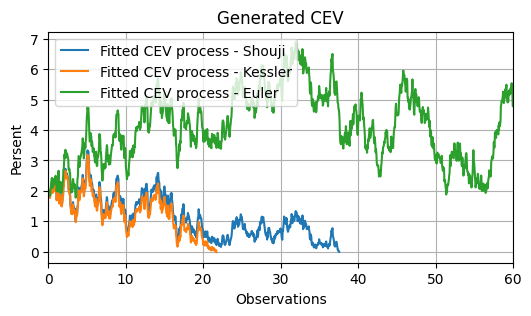

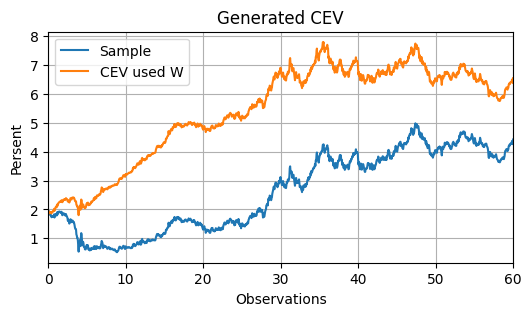

In [44]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = cev_s[i-1] + CEV_pr(cev_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    cev_k[i] = cev_k[i-1] + CEV_pr(cev_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    cev_e[i] = cev_e[i-1] + CEV_pr(cev_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)
    ecev[i] = ecev[i-1] + CEV_pr(ecev[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, cev_s, label="Fitted CEV process - Shouji")
plt.plot(time_line, cev_k, label="Fitted CEV process - Kessler")
plt.plot(time_line, cev_e, label="Fitted CEV process - Euler")
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label='CEV used W')
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

Task. Generate a CKLS process with estimated parameters.

In [45]:
def generate_CKLS_step(S, kappa, mu, sigma, gamma, dt, dW):
    S_adjusted = np.maximum(S, 1e-6)  # Исключаем значения, близкие к нулю
    delta_S = kappa * (mu - S) * dt + sigma * (S_adjusted ** gamma) * dW
    return delta_S

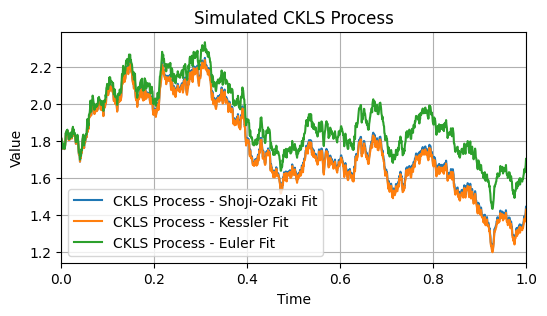

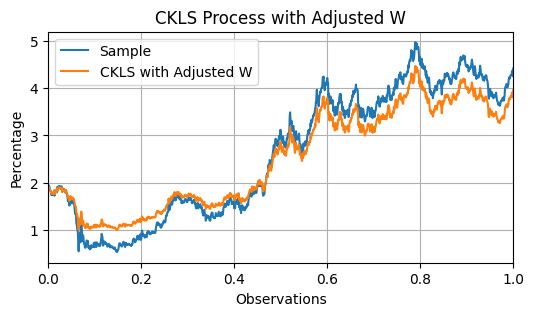

In [46]:
# Параметры временного ряда и начальные условия
T = 1
N = len(sample)
S0 = sample[0]

kappa, mu, sigma, gamma = kessler_p

# Формируем временные точки и винеровский процесс
time_points, dt = np.linspace(0, T, N, retstep=True)
Wiener_proc_values = Wiener_proc(N, T)

# Создаем массивы для хранения значений CKLS-процесса
ckls_shoji, ckls_kessler, ckls_euler = np.zeros(N), np.zeros(N), np.zeros(N)
ckls_shoji[0], ckls_kessler[0], ckls_euler[0] = S0, S0, S0
ckls_with_modified_W = np.zeros(N)
ckls_with_modified_W[0] = S0

# Моделирование CKLS-процесса для каждого метода
for i in range(1, N):
    dW = Wiener_proc_values[i] - Wiener_proc_values[i - 1]
    ckls_shoji[i] = ckls_shoji[i - 1] + generate_CKLS_step(ckls_shoji[i - 1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    ckls_kessler[i] = ckls_kessler[i - 1] + generate_CKLS_step(ckls_kessler[i - 1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    ckls_euler[i] = ckls_euler[i - 1] + generate_CKLS_step(ckls_euler[i - 1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)
    ckls_with_modified_W[i] = ckls_with_modified_W[i - 1] + generate_CKLS_step(ckls_with_modified_W[i - 1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i - 1])

# Построение графика смоделированного процесса CKLS
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(time_points, ckls_shoji, label="CKLS Process - Shoji-Ozaki Fit")
ax.plot(time_points, ckls_kessler, label="CKLS Process - Kessler Fit")
ax.plot(time_points, ckls_euler, label="CKLS Process - Euler Fit")
ax.set_title("Simulated CKLS Process")
ax.set_ylabel("Value")
ax.set_xlabel("Time")
ax.legend()
ax.set_xlim(0, T)
ax.grid()
plt.show()

# График выборки и CKLS процесса с использованием измененного W
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(time_points, sample, label="Sample")
ax.plot(time_points, ckls_with_modified_W, label="CKLS with Adjusted W")
ax.set_title("CKLS Process with Adjusted W")
ax.set_ylabel("Percentage")
ax.set_xlabel("Observations")
ax.legend()
ax.set_xlim(0, T)
ax.grid()
plt.show()

In [47]:
# a) fit using Euler method:

# Choose several models:
model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

#pb = param_bounds[0]
#pg = np.array([1., 0.5])
#m = BrownianMotion()

# Set parameters for estimators:
dt = 1. / 252
K = 1
eu_params = []
oz_params = []
so_params = []
ks_params = []
ex_params = []

#euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    eu_params.append(euler_est)
    oz_params.append(ozaki_est)
    so_params.append(shoji_est)
    ks_params.append(kessler_est)
    ex_params.append(exact_est)

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.663678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.92e-07, constraint violation: 0.00e+00, execution time: 0.083 s.
Final Params: [0.52575792 0.99606105]
Final Likelihood: 1688.5031351392522
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 82, function evaluations: 425, CG iterations: 201, optimality: 5.44e-06, constraint violation: 0.00e+00, execution time: 0.23 s.
Final Params: [0.08517402 8.74386331 0.81883612 0.22428031]
Final Likelihood: 1714.574878581613
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2722.1718500081256
`xtol` termination condition is satisfied.
Number of iterations: 69, function evaluations: 240, CG iterations: 140, optimality: 3.79e-06, constraint violation: 0.00e+00, execution time: 0.17 s.
Final Params: [0.1066357  7.

100%|██████████| 1/1 [00:07<00:00,  7.86s/it]

`gtol` termination condition is satisfied.
Number of iterations: 63, function evaluations: 224, CG iterations: 133, optimality: 2.52e-07, constraint violation: 0.00e+00, execution time: 0.15 s.
Final Params: [0.12451611 6.83542174 0.99600333]
Final Likelihood: 1688.5756297773114
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79286.55610856632
`xtol` termination condition is satisfied.
Number of iterations: 58, function evaluations: 310, CG iterations: 157, optimality: 9.17e-06, constraint violation: 0.00e+00, execution time: 0.15 s.
Final Params: [0.53384366 0.01000671 0.81883098 0.22433494]
Final Likelihood: 1714.529383338915


Task. Calculate the BIC and select the best model. Compare results with solution of Task 1.

In [50]:
from tabulate import tabulate

n = len(sample)

# Функция для расчета BIC через AIC
def calculate_bic_from_aic(aic_value, n, num_params):
    log_likelihood = -0.5 * aic_value
    return num_params * np.log(n) - 2 * log_likelihood

# Список для хранения результатов
results = []

# Итерация по каждому методу и каждой модели

for method, details in methods.items():
    print(f"Processing method: {method}")
    for model_name, model_info in model_configs.items():
        bounds = model_info["limits"]
        initial_guess = model_info["initial"]
        model_instance = model_info["instance"]
        
        # Оценка параметров и получение AIC для текущей модели и метода
        estimator = AnalyticalMLE(sample, bounds, dt, density=density_func(model_instance))
        estimated_params = estimator.estimate_params(initial_guess)
        
        # Извлекаем AIC и рассчитываем BIC на его основе
        aic_value = estimated_params.aic
        num_params = len(estimated_params.params)
        bic_value = calculate_bic_from_aic(aic_value, n, num_params)
        
        # Добавляем результат в список
        results.append([method, model_name, estimated_params.params, aic_value, bic_value])

# for method, details in methods.items():
#     density_func = details["density_func"]
    
#     for model_name, model_info in model_configs.items():
#         bounds = model_info["limits"]
#         initial_guess = model_info["initial"]
#         model_instance = model_info["instance"]
        
#         # Оценка параметров и получение AIC для текущей модели и метода
#         estimator = AnalyticalMLE(sample, bounds, dt, density=density_func(model_instance))
#         estimated_params = estimator.estimate_params(initial_guess)
        
#         # Извлекаем AIC и рассчитываем BIC на его основе
#         aic_value = estimated_params.aic
#         num_params = len(estimated_params.params)
#         bic_value = calculate_bic_from_aic(aic_value, n, num_params)
        
#         # Добавляем результат в список
#         results.append([method, model_name, estimated_params.params, aic_value, bic_value])

# Вывод таблицы результатов
headers = ["Method", "Model", "Params", "AIC", "BIC"]
print(tabulate(results, headers=headers, tablefmt="grid"))


Processing method: Kessler
Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.663678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.92e-07, constraint violation: 0.00e+00, execution time: 0.097 s.
Final Params: [0.52575792 0.99606105]
Final Likelihood: 1688.5031351392522
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325


c:\Users\OneSmiLe\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 82, function evaluations: 425, CG iterations: 201, optimality: 5.44e-06, constraint violation: 0.00e+00, execution time: 0.24 s.
Final Params: [0.08517402 8.74386331 0.81883612 0.22428031]
Final Likelihood: 1714.574878581613
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2722.1718500081256
`xtol` termination condition is satisfied.
Number of iterations: 69, function evaluations: 240, CG iterations: 140, optimality: 3.79e-06, constraint violation: 0.00e+00, execution time: 0.17 s.
Final Params: [0.1066357  7.54333943 0.68420268]
Final Likelihood: 1670.0266317186024
Initial Params: [0.01, 0.2]
Initial Likelihood: -955.697396298052
`gtol` termination condition is satisfied.
Number of iterations: 30, function evaluations: 75, CG iterations: 44, optimality: 3.16e-07, constraint violation: 0.00e+00, execution time: 0.062 s.
Final Params: [0.35407027 0.59508579]
Final Likelihood: 1356.3069592517759
Initial Params: [0.01,

In [47]:
# Implement multiprocessing approach for solving
import multiprocessing
def MLE_Estimator(i):
    # a) fit using Kessler method:

    # Choose several models:
    model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
             IGBM(), OrnsteinUhlenbeck(), CKLS()]

    # Create parametrization templates:
    param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                    [(0.01, 10), (0.01, 2)],                         # GBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
                   ]

    param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                    [0.01, 0.01, 0.01, 0.2],                         # CEV
                    [0.01, 0.01, 0.2],                               # CIR
                    [0.01, 0.2],                                     # GBM
                    [0.01, 0.01, 0.2],                               # IGBM
                    [0.01, 0.01, 0.2],                               # OU
                    [0.01, 0.01, 0.01, 0.2]                          # CKLS
                   ]

    #pb = param_bounds[0]
    #pg = np.array([1., 0.5])
    #m = BrownianMotion()

    # Set parameters for estimators:
    dt = 1. / 252
    K = 1
    eu_params = []
    oz_params = []
    so_params = []
    ks_params = []
    ex_params = []

    #euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

    for k in tqdm(range(K)):
        seed = rnd.randint(1, 10000)
        euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))]
        ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))]
        shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))]
        kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))]
        exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))]
        eu_params.append(euler_est)
        oz_params.append(ozaki_est)
        so_params.append(shoji_est)
        ks_params.append(kessler_est)
        ex_params.append(exact_est)
    return [eu_params,
            oz_params,
            so_params,
            ks_params,
            ex_params]

In [ ]:
# Run estimator with parallel calculating:
K = 100
i_range   = [i for i in range(100)]
pool_obj = multiprocessing.Pool()
answer = pool_obj.map(MLE_Estimator, i_range)

Task 2. USD/Euro Exchange Rates.

Fit a time series of USD/EUR exchange rates over the period Jan 1, 1999 to till now (daily observations)  by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates display in a table for each method. Calculate the AIC and BIC and select the best model. Compare your results with paper (Kirkby et.al., 2022), where period was from Jan 1, 1999 to May 21, 2021 (daily observations).

Dataset: U.S./Euro Foreign Exchange Rate [DEXUSEU], retrieved from FRED, Federal Reserve Bank of St. Louis;
https://fred.stlouisfed.org/series/DEXUSEU

In [ ]:
df_DEXUSEU = pd.read_csv('DEXUSEU.csv')

,DATE,DEXUSEU
0,2019-11-01,1.1169
1,2019-11-04,1.1144
2,2019-11-05,1.107
3,2019-11-06,1.1076
4,2019-11-07,1.1045


In [109]:
df_DEXUSEU = df_DEXUSEU[df_DEXUSEU['DEXUSEU'] != '.']
sample = df_DEXUSEU['DEXUSEU'].values
sample = [float(sample[i]) for i in range(len(sample))]
sample = np.array(sample)

df_DEXUSEU['DEXUSEU'] = np.float64(df_DEXUSEU.DEXUSEU)
df_DEXUSEU['DATE'] = pd.to_datetime(df_DEXUSEU.DATE)

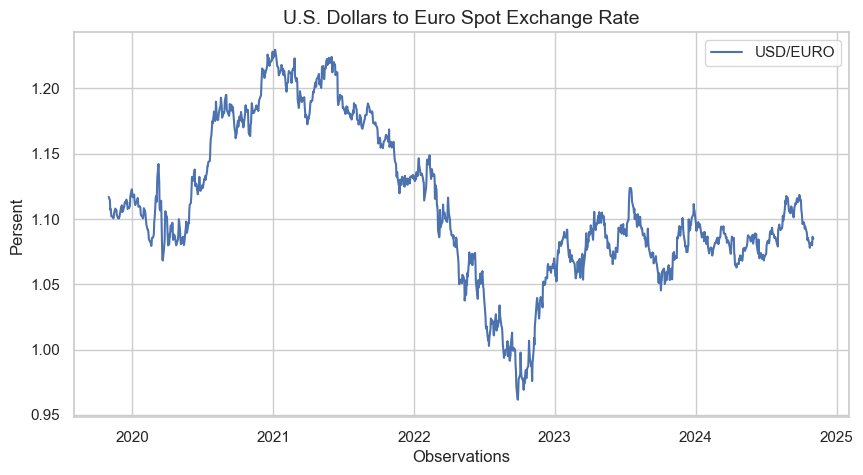

In [110]:
# Plot

figure, ax = plt.subplots(figsize=(10,5))
ax.plot(df_DEXUSEU['DATE'], df_DEXUSEU['DEXUSEU'], label='USD/EURO')
plt.title('U.S. Dollars to Euro Spot Exchange Rate')
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

In [117]:
class ModelEstimator:
    def __init__(self, sample, models, model_names, param_bounds, param_guesses, dt=1./252):
        self.sample = sample
        self.models = models
        self.model_names = model_names
        self.param_bounds = param_bounds
        self.param_guesses = param_guesses
        self.dt = dt
        self.results = {'Kessler': {}, 'Shoji-Ozaki': {}, 'Euler': {}}

    def estimate_params(self, method, model, param_bounds, param_guess):
        """
        Estimate parameters using the given method and model, calculating both AIC and BIC.
        """
        if method == 'Kessler':
            density = KesslerDensity(model)
        elif method == 'Shoji-Ozaki':
            density = ShojiOzakiDensity(model)
        elif method == 'Euler':
            density = EulerDensity(model)
        else:
            raise ValueError(f"Unknown method {method}")
        
        estimator = AnalyticalMLE(self.sample, param_bounds, self.dt, density=density)
        result = estimator.estimate_params(param_guess)
        aic = result.aic
        bic = result.bic
        params = result.params
        return aic, bic, params

    def fit_models(self):
        """
        Estimate parameters for each model using each method, recording both AIC and BIC.
        """
        for method in self.results.keys():
            for i, model in enumerate(self.models):
                aic, bic, params = self.estimate_params(method, model, self.param_bounds[i], self.param_guesses[i])
                self.results[method][self.model_names[i]] = {'aic': aic, 'bic': bic, 'params': params}

    def print_aic_bic_results(self):
        """
        Print AIC and BIC results for all models and methods.
        """
        for method, data in self.results.items():
            
            print(f"AIC and BIC values for {method} estimation:")
            print(f"{'Model':<20} {'AIC':<10} {'BIC':<10} {'Parameters'}")
            
            for model in self.model_names:
                aic = data[model]['aic']
                bic = data[model]['bic']
                params = data[model]['params']
                print(f"{model:<20} {aic:<10.3f} {bic:<10.3f} {params}")
            

    def print_best_model(self):
        """
        Print the best model for each method (based on the lowest AIC and BIC).
        """
        for method, data in self.results.items():
            best_model_aic = min(data, key=lambda x: data[x]['aic'])
            best_model_bic = min(data, key=lambda x: data[x]['bic'])
            best_params_aic = data[best_model_aic]['params']
            best_params_bic = data[best_model_bic]['params']
            
            
            print(f"Best models for {method} estimation:")
            print(f"AIC-based: {best_model_aic:<15} Parameters: {best_params_aic}")
            print(f"BIC-based: {best_model_bic:<15} Parameters: {best_params_bic}")
            

    def print_combined_results(self):
        """
        Print the combined best model results across all methods for both AIC and BIC.
        """
        best_models_aic = {
            method: min(self.results[method], key=lambda x: self.results[method][x]['aic'])
            for method in self.results
        }
        best_models_bic = {
            method: min(self.results[method], key=lambda x: self.results[method][x]['bic'])
            for method in self.results
        }
    
        
        print("Combined Best Models Across All Methods (AIC and BIC):")
        print(f"{'Method':<15} {'AIC Best Model':<20} {'BIC Best Model':<20} {'Parameters (AIC)':<20} {'Parameters (BIC)'}")
        
        for method in self.results:
            best_model_aic = best_models_aic[method]
            best_model_bic = best_models_bic[method]
            best_params_aic = np.array2string(self.results[method][best_model_aic]['params'], precision=3)
            best_params_bic = np.array2string(self.results[method][best_model_bic]['params'], precision=3)
            print(f"{method:<15} {best_model_aic:<20} {best_model_bic:<20} {best_params_aic:<20} {best_params_bic}")
        

In [118]:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), IGBM(), OrnsteinUhlenbeck(), CKLS()]

param_bounds = [
    [(0.01, 10), (0.01, 2)],                         # Brownian Motion
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # CIR
    [(0.01, 10), (0.01, 2)],                         # GBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # IGBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # OU
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
]

param_guess = [
    [0.01, 0.2],                                     # Brownian Motion
    [0.01, 0.01, 0.01, 0.2],                         # CEV
    [0.01, 0.01, 0.2],                               # CIR
    [0.01, 0.2],                                     # GBM
    [0.01, 0.01, 0.2],                               # IGBM
    [0.01, 0.01, 0.2],                               # OU
    [0.01, 0.01, 0.01, 0.2]                          # CKLS
]

In [119]:
class StochasticProcessSimulator:
    def __init__(self, S0, T, N):
        self.S0 = S0
        self.T = T
        self.N = N
        self.time_line, self.dt = np.linspace(0, T, N, retstep=True)
        self.W = self.generate_wiener_process()
        
    def generate_wiener_process(self):
        W = np.zeros(self.N)
        delta = self.T / self.N
        sqrt_delta = np.sqrt(delta)
        for i in range(1, self.N):
            W[i] = W[i-1] + np.random.normal(0, sqrt_delta)
        return W

    # Constant Elasticity of Variance (CEV) process
    def CEV_process(self, S, kappa, mu, sigma, gamma, dW):
        S_non_neg = np.maximum(S, 1e-6)
        dS = kappa * (mu - S_non_neg) * self.dt + sigma * (S_non_neg**gamma) * dW
        return dS

    # Cox-Ingersoll-Ross (CIR) process
    def CIR_process(self, S, kappa, mu, sigma, dW):
        S_non_neg = np.maximum(S, 1e-6)
        dS = kappa * (mu - S_non_neg) * self.dt + sigma * np.sqrt(S_non_neg) * dW
        return dS

    # Ornstein-Uhlenbeck (OU) process
    def OU_process(self, S, kappa, mu, sigma, dW):
        dS = kappa * (mu - S) * self.dt + sigma * dW
        return dS

    # CKLS process
    def CKLS_process(self, S, kappa, mu, sigma, gamma, dW):
        S_non_neg = np.maximum(S, 1e-6)
        dS = kappa * (mu - S_non_neg) * self.dt + sigma * (S_non_neg**gamma) * dW
        return dS

    def generate_paths(self, parameters):
        paths = {key: np.zeros(self.N) for key in parameters.keys()}
        
        # Initialize starting values
        for key in paths:
            paths[key][0] = self.S0
        
        # Generate paths for each model
        for i in range(1, self.N):
            dW = self.W[i] - self.W[i - 1]
            for key, params in parameters.items():
                if "CEV" in key:
                    paths[key][i] = paths[key][i - 1] + self.CEV_process(paths[key][i - 1], *params, dW)
                elif "CIR" in key:
                    paths[key][i] = paths[key][i - 1] + self.CIR_process(paths[key][i - 1], *params, dW)
                elif "OU" in key:
                    paths[key][i] = paths[key][i - 1] + self.OU_process(paths[key][i - 1], *params, dW)
                elif "CKLS" in key:
                    paths[key][i] = paths[key][i - 1] + self.CKLS_process(paths[key][i - 1], *params, dW)
        
        return paths

In [121]:
# Initialize the ModelEstimator
estimator = ModelEstimator(sample, model, model_name, param_bounds, param_guess)

estimator.fit_models()
estimator.print_aic_bic_results()
estimator.print_best_model()
estimator.print_combined_results()

Initial Params: [0.01, 0.2]
Initial Likelihood: 4215.288351871408
`xtol` termination condition is satisfied.
Number of iterations: 149, function evaluations: 456, CG iterations: 272, optimality: 3.76e-05, constraint violation: 0.00e+00, execution time: 0.46 s.
Final Params: [0.01001301 0.08014153]
Final Likelihood: 4833.301567785224
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -19404.191448983693
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1320, CG iterations: 888, optimality: 4.44e-01, constraint violation: 0.00e+00, execution time:  1.2 s.
Final Params: [0.17635699 1.03828776 0.08000351 0.01132176]
Final Likelihood: 4833.591701112129
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4159.23861990984
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1008, CG iterations: 739, optimality: 3.86e-01, constraint violation: 0.00e+00, execution time:  1.0 s.


In [122]:
date_2 = df_DEXUSEU[df_DEXUSEU['DEXUSEU'] != '.']

# Make valid numerical sample
sample_2 = date_2['DEXUSEU'].values
sample_2 = [float(sample_2[i]) for i in range(len(sample_2))]
sample_2 = np.array(sample_2)

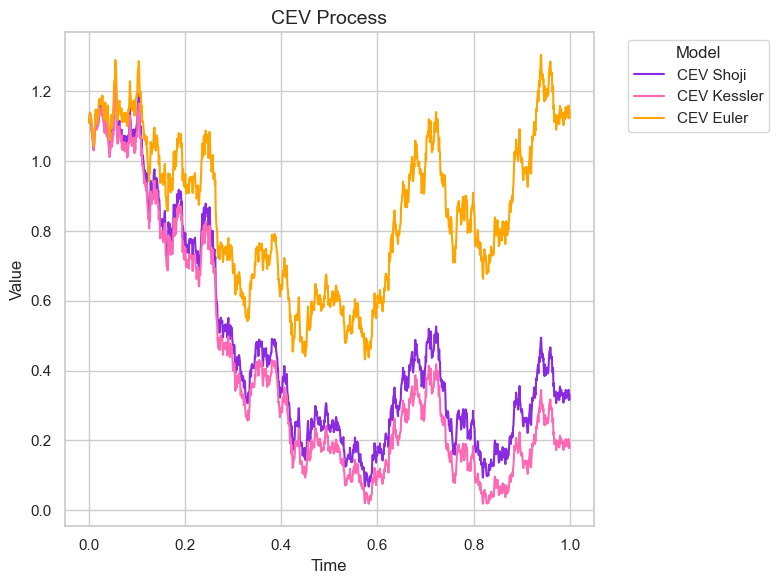

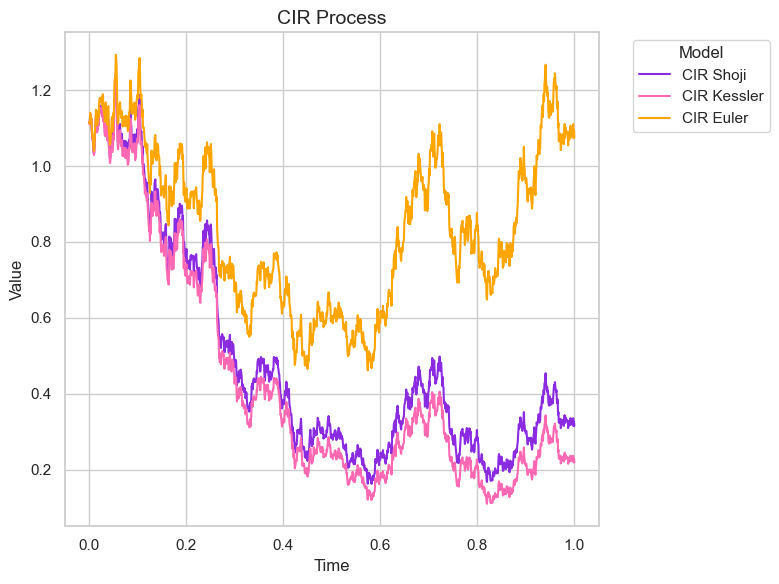

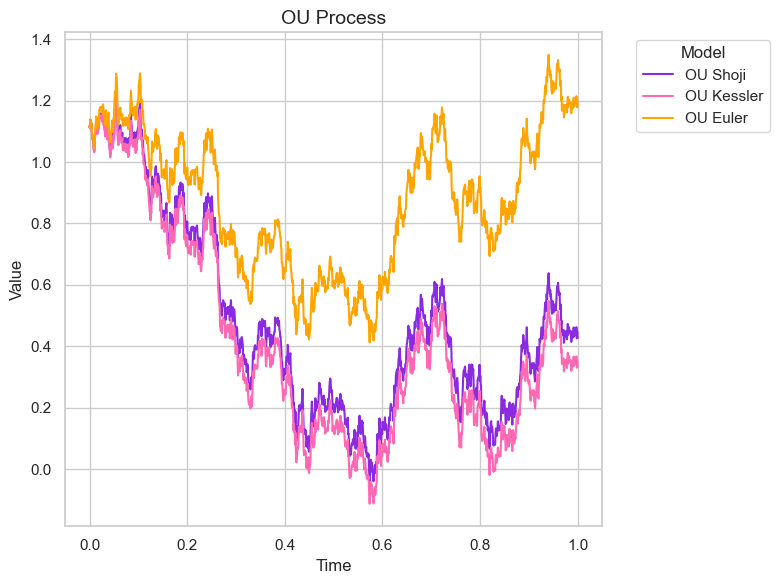

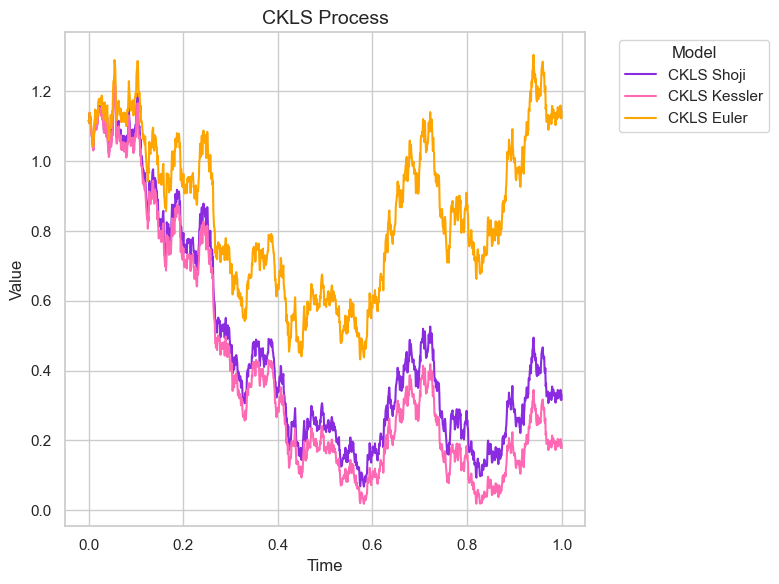

In [ ]:
import seaborn as sns

# Подготовим данные для визуализации
data = []
for process in process_names:
    for key, path in paths.items():
        if key.startswith(process):
            for t, value in zip(simulator.time_line, path):  # Для каждого времени и значения пути
                data.append({
                    'Time': t,
                    'Value': value,
                    'Process': process,
                    'Model': key
                })

df = pd.DataFrame(data)

# Задаем список цветов
color_palette = ['#8A2BE2', '#FF69B4', '#FFA500']  # Фиолетовый, розовый, оранжевый

# Создаем 4 отдельных графика по одному для каждого процесса
for i, process in enumerate(process_names):
    process_data = df[df['Process'] == process]
    
    plt.figure(figsize=(8, 6))  # Для каждого процесса создаем отдельное окно
    sns.lineplot(x='Time', y='Value', hue='Model', data=process_data, palette=color_palette)
    plt.title(f'{process} Process')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')  # Легенда справа от графика
    plt.tight_layout()  # Подгонка графика
    plt.show()

---

Task 3. U.S. Interest Rates.

Fit a time series of IRates over the period  from 06/1964
to 12/1989 (monthly data) by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates
display in Table for each method. Calculate the AIC and BIC, and select the best model. Compare your results with paper by [Brouste et. al.](https://www.semanticscholar.org/paper/The-YUIMA-Project%3A-A-Computational-Framework-for-of-Brouste-Fukasawa/e9a4696779261dbeca55f316943307d7da5d3d1b) (page 43):

$$dX_t = (2.08 - 0.26 X_t)dt + 0.13 X^{1.44}_t dW_t.$$

Dataset: In order to obtain the data one can open browser, type the address https://rdrr.io/snippets/ and run the code in R language:



```
library(Ecdat)
data(Irates)
rates = Irates[, "r1"]; rates
plot(rates)
```



In [140]:
df_rate = pd.read_excel('D:/Сириус/2 год/ССП/Rate.xlsx', index_col = 0)
data_3 = np.array(df_rate)
data_3 = data_3.flatten()
data_3 = pd.DataFrame(data_3)
data_3 = data_3.dropna()

data_3.columns = ['IRates']
date_range = pd.date_range(start="1946-12-01", end="1991-02-01", freq="MS")
data_3['date']= date_range
data_3['date']== data_3['date'].dt.strftime('%Y-%m')

sample_3 = np.array(data_3['IRates'])
data_3

,IRates,date
11,0.325,1946-12-01
12,0.322,1947-01-01
13,0.326,1947-02-01
14,0.318,1947-03-01
15,0.302,1947-04-01
...,...,...
537,6.709,1990-10-01
538,6.659,1990-11-01
539,5.867,1990-12-01
540,5.953,1991-01-01


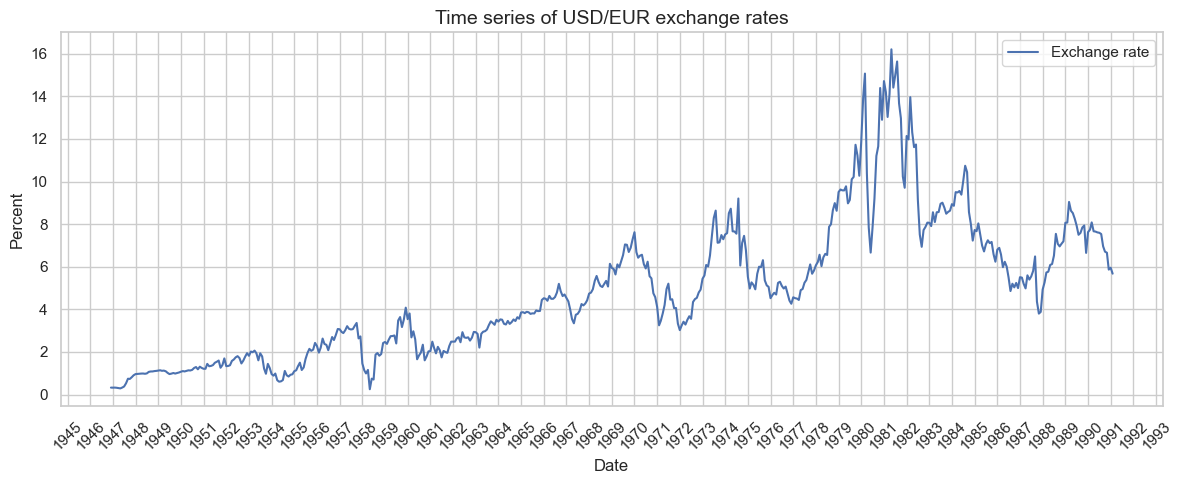

In [ ]:
import seaborn as sns
import matplotlib.dates as mdates

# Создаём график
plt.figure(figsize=(12, 5))

# Используем Seaborn для построения линейного графика
sns.lineplot(x='date', y='IRates', data=data_3, label='Exchange rate')

# Настройка оси X для отображения годов
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Поворот меток на оси X
plt.xticks(rotation=45)

# Заголовок и подписи осей
plt.title('Time series of USD/EUR exchange rates')
plt.ylabel('Percent')
plt.xlabel('Date')

# Легенда
plt.legend()

# Подгонка расположения элементов графика
plt.tight_layout()

# Отображение графика
plt.show()

In [142]:
estimator_3 = ModelEstimator(sample_3, model, model_name, param_bounds, param_guess)

estimator_3.fit_models()
estimator_3.print_aic_bic_results()
estimator_3.print_best_model()
estimator_3.print_combined_results()

Initial Params: [0.01, 0.2]
Initial Likelihood: -24674.766899043825
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 102, CG iterations: 42, optimality: 8.55e-04, constraint violation: 0.00e+00, execution time: 0.09 s.
Final Params: [8.29542793 1.99999964]
Final Likelihood: -3404.746026668633
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35672.5169125899


c:\Users\OneSmiLe\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 37, function evaluations: 205, CG iterations: 98, optimality: 1.69e+02, constraint violation: 0.00e+00, execution time:  0.1 s.
Final Params: [0.65585893 0.7398841  2.29050535 0.71287424]
Final Likelihood: -376.566706227482
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -18252.900715605694
`xtol` termination condition is satisfied.
Number of iterations: 63, function evaluations: 264, CG iterations: 120, optimality: 5.50e-02, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [3.61131931 6.03311456 1.99518302]
Final Likelihood: -645.2128876984586
Initial Params: [0.01, 0.2]
Initial Likelihood: -10138.910068519162
`xtol` termination condition is satisfied.
Number of iterations: 23, function evaluations: 39, CG iterations: 24, optimality: 3.71e+02, constraint violation: 0.00e+00, execution time: 0.038 s.
Final Params: [0.48717187 1.09611534]
Final Likelihood: -630.1120355624482
Initial Params: [0.01

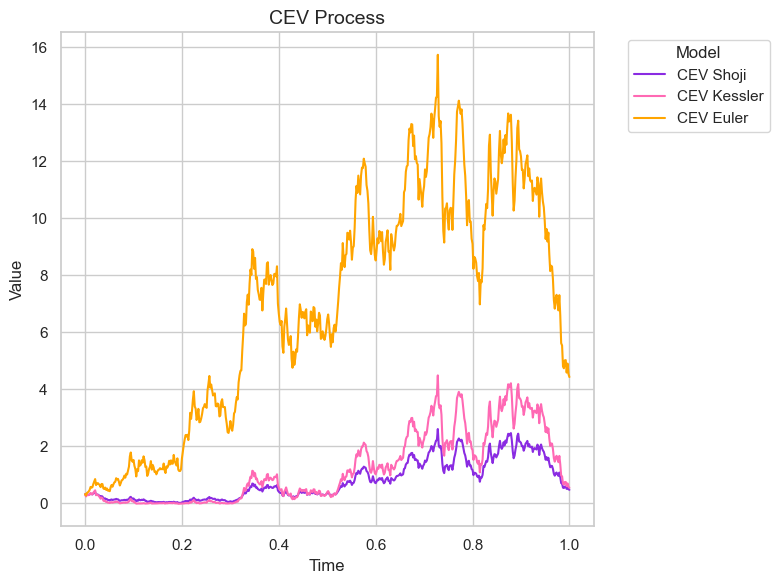

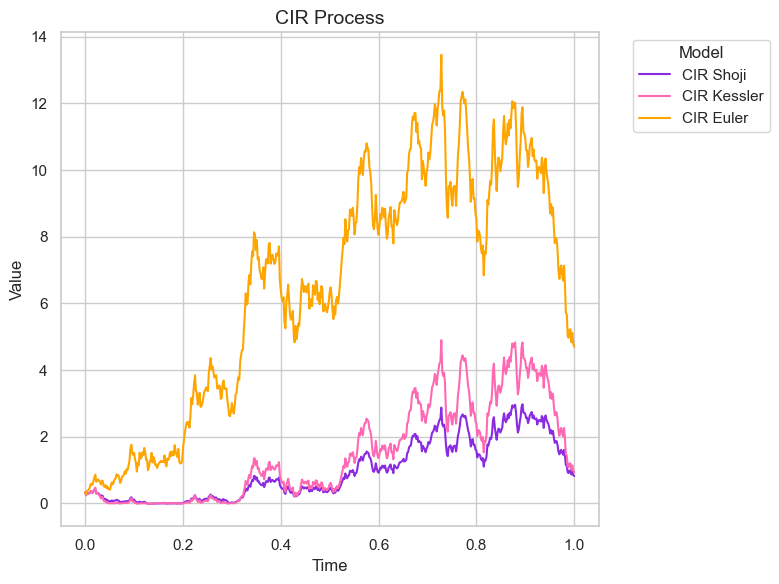

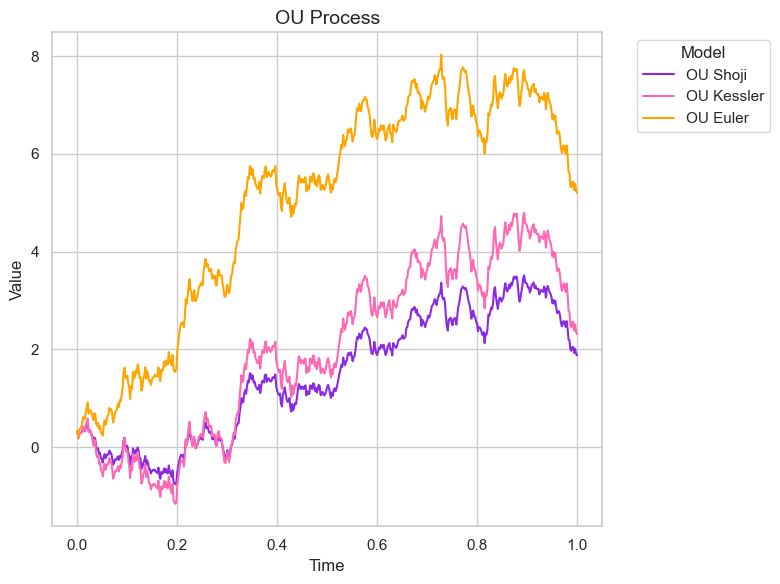

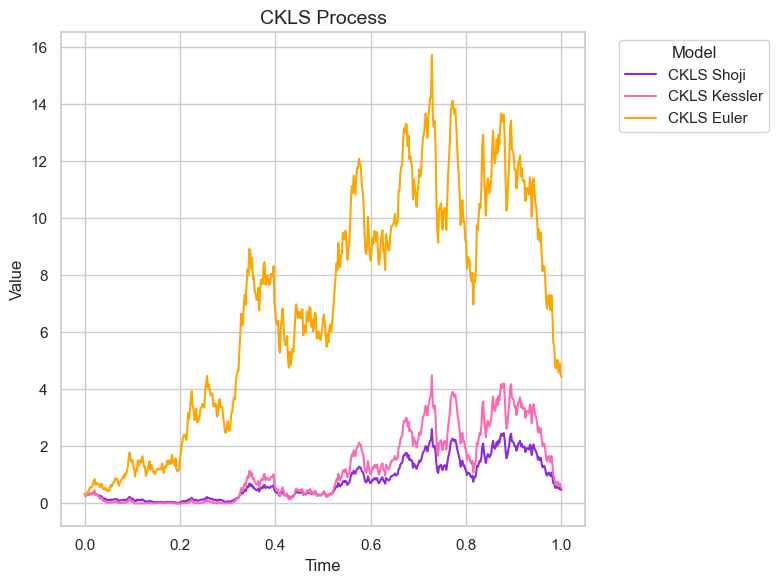

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Подготовим данные для визуализации
sample_3 = np.array(data_3['IRates'])
S0 = sample_3[0]
T = 1
N = len(sample_3)
simulator = StochasticProcessSimulator(S0, T, N)

shoji_ozaki_p = [0.656, 0.74,  2.291, 0.713]
kessler_p     = [1.022, 1.039, 3.36,  0.579]
euler_p       = [3.342, 5.569, 3.271, 0.593]

parameters = {
    'CEV Shoji': shoji_ozaki_p,
    'CEV Kessler': kessler_p,
    'CEV Euler': euler_p,
    'CIR Shoji': shoji_ozaki_p[:3],
    'CIR Kessler': kessler_p[:3],
    'CIR Euler': euler_p[:3],
    'OU Shoji': shoji_ozaki_p[:3],
    'OU Kessler': kessler_p[:3],
    'OU Euler': euler_p[:3],
    'CKLS Shoji': shoji_ozaki_p,
    'CKLS Kessler': kessler_p,
    'CKLS Euler': euler_p,
}

# Генерация путей
paths = simulator.generate_paths(parameters)

# Подготовка данных для Seaborn
data = []
for process in process_names:
    for key, path in paths.items():
        if key.startswith(process):
            for t, value in zip(simulator.time_line, path):  # Для каждого времени и значения пути
                data.append({
                    'Time': t,
                    'Value': value,
                    'Process': process,
                    'Model': key
                })

df = pd.DataFrame(data)

# Задаем список цветов
color_palette = ['#8A2BE2', '#FF69B4', '#FFA500']  # Фиолетовый, розовый, оранжевый

# Создаем 4 отдельных графика по одному для каждого процесса
for i, process in enumerate(process_names):
    process_data = df[df['Process'] == process]
    
    plt.figure(figsize=(8, 6))  # Для каждого процесса создаем отдельное окно
    sns.lineplot(x='Time', y='Value', hue='Model', data=process_data, palette=color_palette)
    plt.title(f'{process} Process')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')  # Легенда справа от графика
    plt.tight_layout()  # Подгонка графика
    plt.show()

---

Task 4.

Take a dual-listed security (for instance, Apple, Google, Amazon), which trade simultaneously on two exchanges. Fit a time series of spread over the 5 years period (day data) by CEV, CIR, OU, CKLS models.

For example, one can use the paper by [Bertram, 2009](https://https://www.sciencedirect.com/science/article/pii/S0378437109002829)
where a spread constructed on the dual-listed security, ANZ Bank (ANZ). Calculate the AIC and BIC, and select the best model.

Hint. Use refs for selection a dual-listed security. Calculate the AIC and BIC, and select the best model.

https://live.euronext.com/en/product/equities/US0378331005-MTAH

https://stockanalysis.com/list/indian-stocks-us/

In [145]:
!pip install yfinance

Tesla (TSLA) — торгуется на бирже NASDAQ в США и на Лондонской фондовой бирже (LSE)

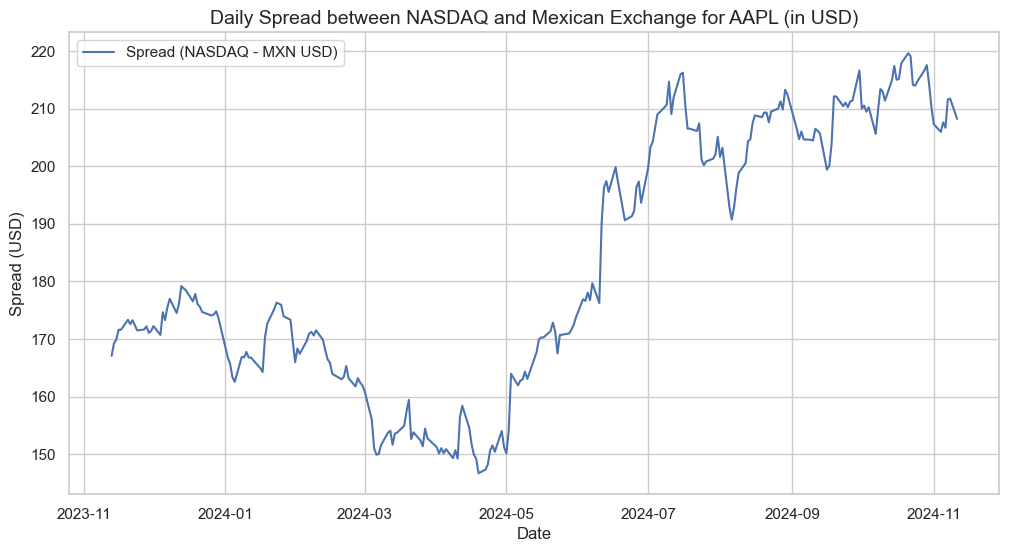

In [180]:
import yfinance as yf
import matplotlib.pyplot as plt

# Получение данных для тикеров
apple_nasdaq = yf.Ticker("AAPL").history(period='1y', interval='1d')
apple_mexico = yf.Ticker("AMX").history(period='1y', interval='1d')

# Расчет спрэда
sample_4 = (apple_nasdaq['Close'] - apple_mexico['Close']).abs()

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(sample_4, label="Spread (NASDAQ - MXN USD)")
plt.title("Daily Spread between NASDAQ and Mexican Exchange for AAPL (in USD)")
plt.xlabel("Date")
plt.ylabel("Spread (USD)")
plt.legend()
plt.show()

In [175]:
estimator = ModelEstimator(sample_4, model, model_name, param_bounds, param_guess)

estimator.fit_models()
estimator.print_aic_bic_results()
estimator.print_best_model()
estimator.print_combined_results()

Initial Params: [0.01, 0.2]
Initial Likelihood: 860.3470361661082


c:\Users\OneSmiLe\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 138, CG iterations: 32, optimality: 8.52e+01, constraint violation: 0.00e+00, execution time: 0.93 s.
Final Params: [0.1663328 0.0102309]
Final Likelihood: 1470.015414509426
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -718.63647785377
`xtol` termination condition is satisfied.
Number of iterations: 86, function evaluations: 505, CG iterations: 223, optimality: 1.58e-01, constraint violation: 0.00e+00, execution time:  4.8 s.
Final Params: [0.01000396 0.03016512 0.04011958 0.20295445]
Final Likelihood: 872.9623115587827
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 212.7006904433709
`xtol` termination condition is satisfied.
Number of iterations: 35, function evaluations: 160, CG iterations: 41, optimality: 2.50e-05, constraint violation: 0.00e+00, execution time:  1.5 s.
Final Params: [0.01000019 0.01484592 0.01000038]
Final Likelihood: 868.648503375513
Initial Params: [0.

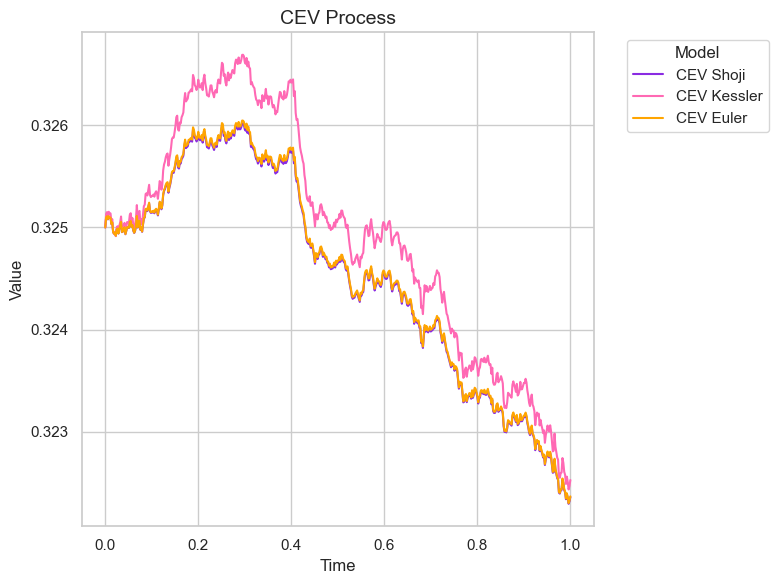

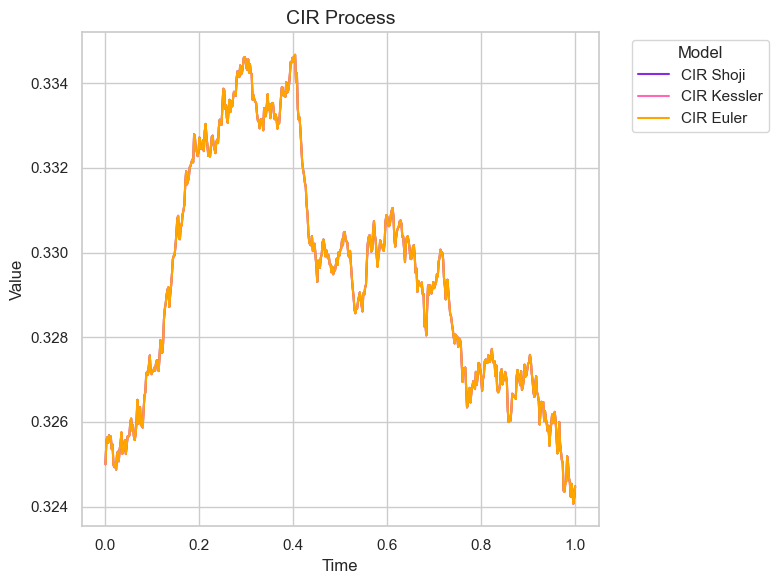

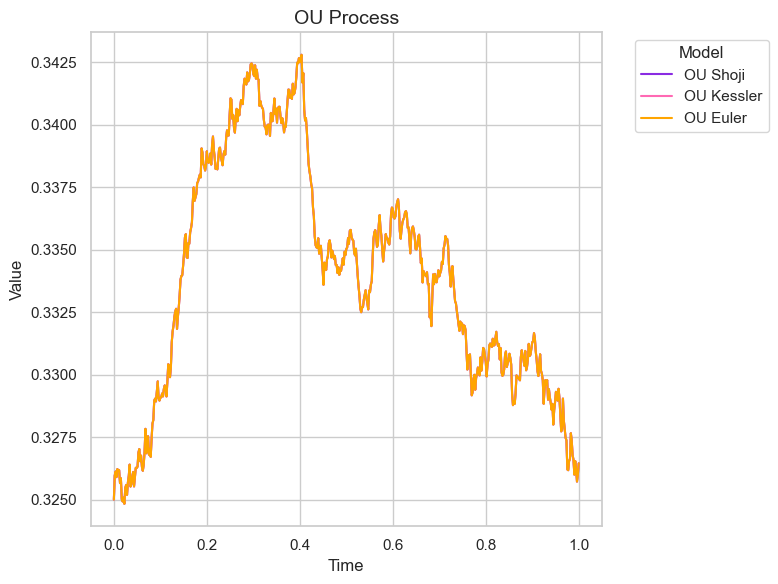

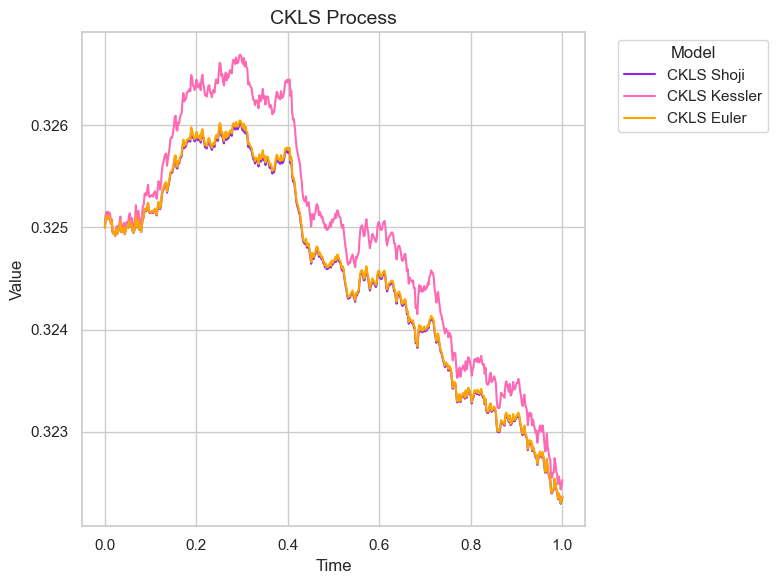

In [182]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Подготовка данных
sample_3 = np.array(data_3['IRates'])
S0 = sample_3[0]
T = 1
N = len(sample_3)
simulator = StochasticProcessSimulator(S0, T, N)

shoji_ozaki_p = [0.01, 0.01, 0.01, 1.999]
kessler_p = [0.01, 0.01, 0.01, 1.736]
euler_p = [0.01, 0.01, 0.01, 1.986]

parameters = {
    'CEV Shoji': shoji_ozaki_p,
    'CEV Kessler': kessler_p,
    'CEV Euler': euler_p,
    'CIR Shoji': shoji_ozaki_p[:3],
    'CIR Kessler': kessler_p[:3],
    'CIR Euler': euler_p[:3],
    'OU Shoji': shoji_ozaki_p[:3],
    'OU Kessler': kessler_p[:3],
    'OU Euler': euler_p[:3],
    'CKLS Shoji': shoji_ozaki_p,
    'CKLS Kessler': kessler_p,
    'CKLS Euler': euler_p,
}

# Генерация путей
paths = simulator.generate_paths(parameters)

# Подготовка данных для Seaborn
data = []
for process in ['CEV', 'CIR', 'OU', 'CKLS']:
    for key, path in paths.items():
        if key.startswith(process):
            for t, value in zip(simulator.time_line, path):  # Для каждого времени и значения пути
                data.append({
                    'Time': t,
                    'Value': value,
                    'Process': process,
                    'Model': key
                })

df = pd.DataFrame(data)

# Задаем список цветов
color_palette = ['#8A2BE2', '#FF69B4', '#FFA500']  # Фиолетовый, розовый, оранжевый

# Создаем 4 отдельных графика по одному для каждого процесса
for i, process in enumerate(['CEV', 'CIR', 'OU', 'CKLS']):
    process_data = df[df['Process'] == process]
    
    plt.figure(figsize=(8, 6))  # Для каждого процесса создаем отдельное окно
    sns.lineplot(x='Time', y='Value', hue='Model', data=process_data, palette=color_palette)
    plt.title(f'{process} Process')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')  # Легенда справа от графика
    plt.tight_layout()  # Подгонка графика
    plt.show()